<a href="https://colab.research.google.com/github/mohmaed7777/NLP-for-COVID-19-Research-Preprint/blob/main/COVID_19_Research_Preprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print('====================!===============!')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
====================!===============!


In [163]:
data = pd.read_csv('/content/COVID-19-Preprint-Data_ver5.csv')

In [164]:
data.rename({'Uploaded Site':'Source'}, axis=1, inplace=True)

In [165]:
data.head()

,DOI,Date of Upload,Title of preprint,Preprint Link,Abstract,Number of Authors,Authors,Author(s) Institutions,Source
0,10.1101/2020.06.19.20135996,2020-06-20,The support needs of Australian primary health...,http://medrxiv.org/cgi/content/short/2020.06.1...,Aim: To identify Australian primary healthcare...,7,"['Elizabeth Halcomb', 'Anna Williams', 'Christ...","{""University of Wollongong"": 6, ""University of...",medrxiv
1,10.1101/2020.06.18.20135103,2020-06-20,Modeling quantitative traits for COVID-19 case...,http://medrxiv.org/cgi/content/short/2020.06.1...,Medical practitioners record the condition sta...,6,"['Nuria Queralt-Rosinach', 'Susan Bello', 'Rob...","{""Leids Universitair Medisch Centrum"": 1, ""The...",medrxiv
2,10.1101/2020.06.19.20135905,2020-06-20,SARS-CoV-2 RT-PCR profile in 298 Indian COVID-...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: Despite being in the 5th month of ...,9,"['bisakh bhattacharya', 'Rohit Kumar', 'Dr. Ve...","{""AIIMS, New Delhi"": 8, ""All India Institute o...",medrxiv
3,10.1101/2020.06.19.20135491,2020-06-20,Inhaled corticosteroid use and risk COVID-19 r...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: Early descriptions of the coronavi...,33,"['- The OpenSAFELY Collaborative', 'Anna Schul...","{"""": 1, ""London School of Hygiene and Tropical...",medrxiv
4,10.1101/2020.06.19.20135533,2020-06-20,The immediate psychological response of the ge...,http://medrxiv.org/cgi/content/short/2020.06.1...,Background: The health and economic burden pan...,4,"['Royes Joseph', 'Dhfer Alshayban', 'Jisha M L...","{""College of Clinical Pharmacy, Imam Abdulrahm...",medrxiv


In [166]:
data.Source.value_counts()

medrxiv    4433
biorxiv    1102
Name: Source, dtype: int64

In [167]:
data.isnull().sum()

DOI                       0
Date of Upload            0
Title of preprint         0
Preprint Link             0
Abstract                  0
Number of Authors         0
Authors                   0
Author(s) Institutions    0
Source                    0
dtype: int64

In [168]:
data.dtypes

DOI                       object
Date of Upload            object
Title of preprint         object
Preprint Link             object
Abstract                  object
Number of Authors          int64
Authors                   object
Author(s) Institutions    object
Source                    object
dtype: object

In [169]:
df_uniques = data.nunique() 
# Count number of distinct elements in specified axis. 
#Return Series with number of distinct elements. Can ignore NaN values.
df_uniques

DOI                       5535
Date of Upload             151
Title of preprint         5532
Preprint Link             5535
Abstract                  5530
Number of Authors           73
Authors                   5414
Author(s) Institutions    5352
Source                       2
dtype: int64

In [170]:
binary_vals = list(df_uniques[df_uniques == 2].index) # Create alist for our bin_vales (composed of at least two values)
binary_vals

['Source']

In [171]:
from sklearn.preprocessing import LabelBinarizer

In [172]:
lb = LabelBinarizer()

In [173]:
for col in binary_vals:
  data[col] = lb.fit_transform(data[col])

In [174]:
data.Source.dtypes

dtype('int64')

In [175]:
data.Source.value_counts()

1    4433
0    1102
Name: Source, dtype: int64

In [176]:
data.columns

Index(['DOI', 'Date of Upload', 'Title of preprint', 'Preprint Link',
       'Abstract', 'Number of Authors', 'Authors', 'Author(s) Institutions',
       'Source'],
      dtype='object')

In [177]:
data.drop(['DOI', 'Date of Upload', 'Title of preprint', 'Preprint Link', 'Number of Authors', 'Authors', 'Author(s) Institutions'], axis=1, inplace=True)

In [178]:
data.head()

,Abstract,Source
0,Aim: To identify Australian primary healthcare...,1
1,Medical practitioners record the condition sta...,1
2,Background: Despite being in the 5th month of ...,1
3,Background: Early descriptions of the coronavi...,1
4,Background: The health and economic burden pan...,1


In [179]:
data.isnull().sum()

Abstract    0
Source      0
dtype: int64

Text(0, 0.5, 'Count')

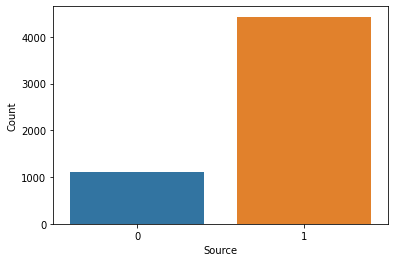

In [180]:
counts = data['Source'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Source')
plt.ylabel('Count')

#**Text preprocessing:**

In [148]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [151]:
vocab_size = 20000
embedding_dim = 16
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Abstract'],data['Source'],test_size = 0.2)

In [153]:
#X_train, X_test, y_train, y_test = X_train.tolist(), X_test.tolist() , y_train.tolist() , y_test.tolist()
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [154]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [157]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [158]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [159]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,391,489
Trainable params: 1,391,489
Non-trainable params: 0
_________________________________________________________________
